# BERT Embeddings Clustering Analysis

This notebook performs clustering analysis on H&M product articles using pre-computed BERT embeddings.
The BERT embeddings capture semantic information from product descriptions, enabling meaningful product groupings.


In [1]:
import sys
sys.path.append('../../')

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available. Install with: pip install umap-learn")

try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False
    print("HDBSCAN not available. Install with: pip install hdbscan")

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

## 1. Data Loading and Exploration


In [2]:
# Load BERT embeddings
print("Loading BERT embeddings...")
bert_df = pl.read_parquet('../../data/features/bert/bert_embeddings.parquet')

print(f"Dataset shape: {bert_df.shape}")
print(f"Memory usage: {bert_df.estimated_size() / 1024**2:.1f} MB")
print(f"Columns: {len(bert_df.columns)} (article_id + {len(bert_df.columns)-1} BERT features)")

# Display basic statistics
bert_df.head()

Loading BERT embeddings...
Dataset shape: (42229, 769)
Memory usage: 124.0 MB
Columns: 769 (article_id + 768 BERT features)


article_id,bert_001,bert_002,bert_003,bert_004,bert_005,bert_006,bert_007,bert_008,bert_009,bert_010,bert_011,bert_012,bert_013,bert_014,bert_015,bert_016,bert_017,bert_018,bert_019,bert_020,bert_021,bert_022,bert_023,bert_024,bert_025,bert_026,bert_027,bert_028,bert_029,bert_030,bert_031,bert_032,bert_033,bert_034,bert_035,bert_036,…,bert_732,bert_733,bert_734,bert_735,bert_736,bert_737,bert_738,bert_739,bert_740,bert_741,bert_742,bert_743,bert_744,bert_745,bert_746,bert_747,bert_748,bert_749,bert_750,bert_751,bert_752,bert_753,bert_754,bert_755,bert_756,bert_757,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767,bert_768
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
816591001,-0.015659,0.012156,0.010178,-0.006604,-0.039259,-0.018793,-0.007029,0.054467,-0.034701,-0.008512,0.070179,0.018095,0.034471,0.033576,0.094397,0.003092,-0.055582,0.002851,0.051617,-0.005365,0.025957,0.020131,0.000646,-0.001181,0.010801,-0.036969,-0.010229,0.040888,-0.005502,-0.000103,0.076183,-0.012406,-0.023416,-0.068657,0.000002,-0.000894,…,-0.054481,-0.023353,0.005695,-0.034331,-0.02045,0.072826,-0.067931,0.005918,0.022829,-0.047841,0.02728,0.004846,-0.004082,0.018529,0.02017,0.014933,0.021912,-0.020965,0.006171,0.053716,0.008077,0.046846,0.024844,0.010362,0.006734,1.9350e-34,-0.009219,-0.127457,0.013274,0.050405,0.011029,0.002934,0.070942,0.027207,-0.000197,-0.013809,0.006784
804472003,0.005563,0.005978,-0.026642,0.002938,-0.027864,0.003424,0.001553,0.018717,0.018902,-0.004157,0.000965,0.015299,0.05248,0.112323,0.072043,-0.03552,-0.022659,-0.012899,0.003428,-0.026845,0.022018,0.038685,-0.010421,0.027536,0.012282,-0.034946,0.002565,0.000958,0.002286,0.025895,0.094062,0.00401,-0.036547,-0.048726,0.000002,-0.018688,…,-0.029814,-0.065162,0.057358,0.004198,-0.010654,-0.018581,-0.041464,0.051404,-0.018781,-0.077134,-0.013477,0.010288,0.006449,0.014299,0.07041,0.00431,0.037104,0.004784,-0.076596,0.022273,0.029969,0.049993,0.0013,-0.007544,0.011644,1.9875e-34,0.019272,-0.066649,0.023891,0.003674,0.029417,0.015441,0.041853,-0.015929,0.024076,0.007616,-0.000851
693915001,-0.035382,0.025676,0.020326,-0.009956,-0.0252,-0.040034,-0.055042,0.048816,-0.043896,-0.034095,0.014015,0.03632,0.052355,0.040688,0.101161,-0.017168,-0.015411,-0.030049,-0.02938,0.001041,0.012573,0.01813,-0.010806,-0.000751,0.039573,-0.036114,-0.030136,0.002133,-0.019197,0.039195,0.090534,0.003774,-0.002759,-0.079025,0.000002,-0.008549,…,-0.004818,-0.020465,0.013445,0.020855,-0.020556,0.008172,-0.041254,0.024847,0.006655,-0.064195,-0.015331,0.021835,-0.000923,-0.008696,0.052818,-0.006522,-0.001527,-0.018466,-0.047959,0.0397,0.023257,0.051558,0.017016,0.046344,0.002421,1.5923e-34,0.016653,-0.02932,-0.005469,0.051259,0.01495,0.000143,-0.002265,-0.006005,0.03819,-0.028675,-0.008054
790904007,-0.035949,0.046203,0.011405,0.01268,-0.055287,-0.026921,-0.039075,0.056623,-0.054116,-0.03501,0.011305,0.007535,0.039332,0.022054,0.082046,-0.000029,-0.024672,-0.010841,-0.049222,-0.01248,-0.003162,-0.002767,-0.001446,-0.001519,0.064139,-0.011927,-0.056071,-0.008529,-0.008399,0.05896,0.06918,0.020556,-0.025252,-0.053308,0.000002,-0.013209,…,-0.010176,0.001974,0.033378,0.036652,-0.035307,-0.012416,-0.021775,0.038971,0.031761,-0.053834,-0.029495,0.005277,-0.004412,-0.029428,0.054736,-0.018975,0.00354,-0.011066,-0.045968,0.013938,0.019726,0.035718,0.028495,0.006232,0.005376,1.6376e-34,0.02205,-0.03512,-0.017729,0.066212,0.005572,-0.005966,0.043238,-0.018493,0.046377,-0.029211,-0.009323
829618001,0.017185,0.015238,-0.031034,-0.029762,-0.018644,0.06515,0.003714,0.017217,-0.035679,0.018255,0.008036,-0.006915,0.024826,0.095959,0.044352,-0.028764,-0.048612,0.0308,-0.001608,0.015041,0.013765,0.01781,-0.039813,-0.011494,0.061811,-0.0

In [3]:
# Extract embeddings matrix and article IDs
article_ids = bert_df.get_column('article_id').to_numpy()
embedding_cols = [col for col in bert_df.columns if col.startswith('bert_')]
embeddings = bert_df.select(embedding_cols).to_numpy()

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding dimensions: {len(embedding_cols)}")
print(f"Data type: {embeddings.dtype}")

# Check for missing values
missing_count = np.isnan(embeddings).sum()
print(f"Missing values: {missing_count}")

# Basic statistics
print(f"\nEmbedding statistics:")
print(f"Mean: {embeddings.mean():.4f}")
print(f"Std: {embeddings.std():.4f}")
print(f"Min: {embeddings.min():.4f}")
print(f"Max: {embeddings.max():.4f}")

Embeddings shape: (42229, 768)
Embedding dimensions: 768
Data type: float32
Missing values: 0

Embedding statistics:
Mean: 0.0002
Std: 0.0361
Min: -0.2293
Max: 0.2178


## 2. Dimensionality Reduction for Visualisation


Performing PCA...
PCA explained variance ratio: [0.09277001 0.08266429 0.08014986 0.05181008 0.03786648 0.03684546
 0.03182542 0.0238599  0.02037073 0.01990532]
Cumulative explained variance (50 components): 0.793


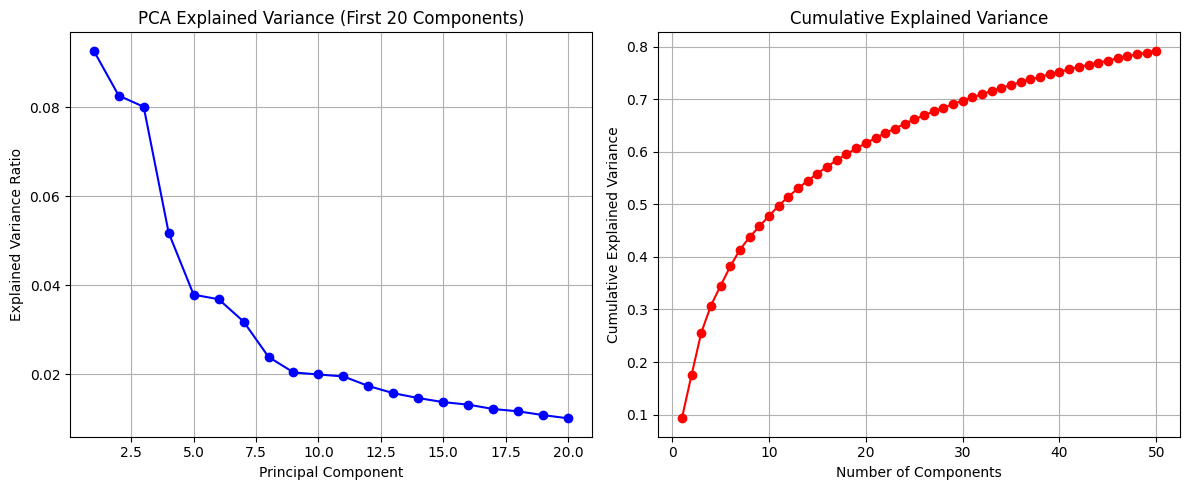

In [4]:
# PCA for initial dimensionality reduction
print("Performing PCA...")
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_[:10]}")
print(f"Cumulative explained variance (50 components): {pca.explained_variance_ratio_.sum():.3f}")

# Plot explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 21), pca.explained_variance_ratio_[:20], 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance (First 20 Components)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 51), np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

Performing t-SNE...
t-SNE shape: (42229, 2)


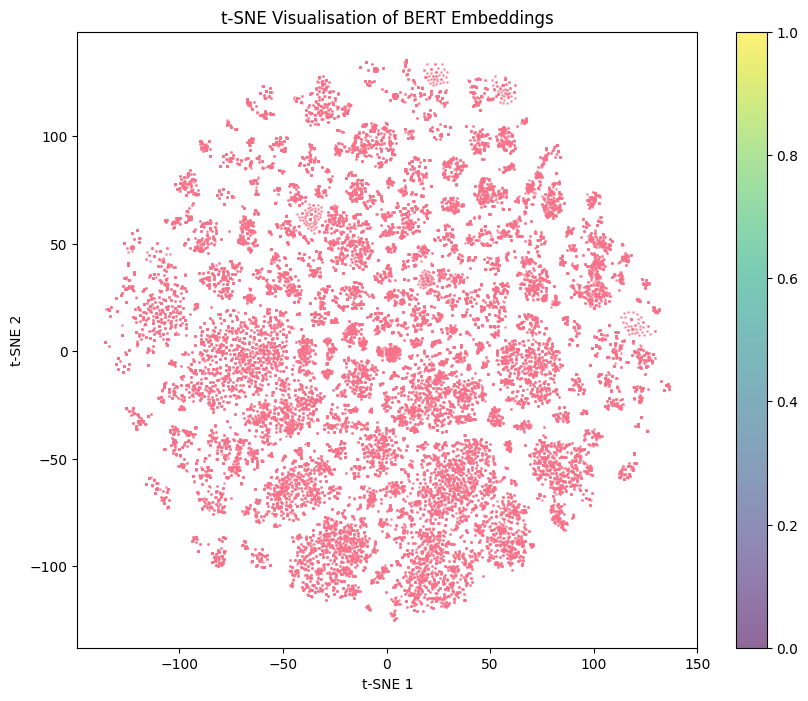

In [5]:
# t-SNE for 2D visualisation (using PCA-reduced data for speed)
print("Performing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

print(f"t-SNE shape: {embeddings_tsne.shape}")

# Plot t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.6, s=1)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualisation of BERT Embeddings')
plt.legend()
plt.show()

Performing UMAP...


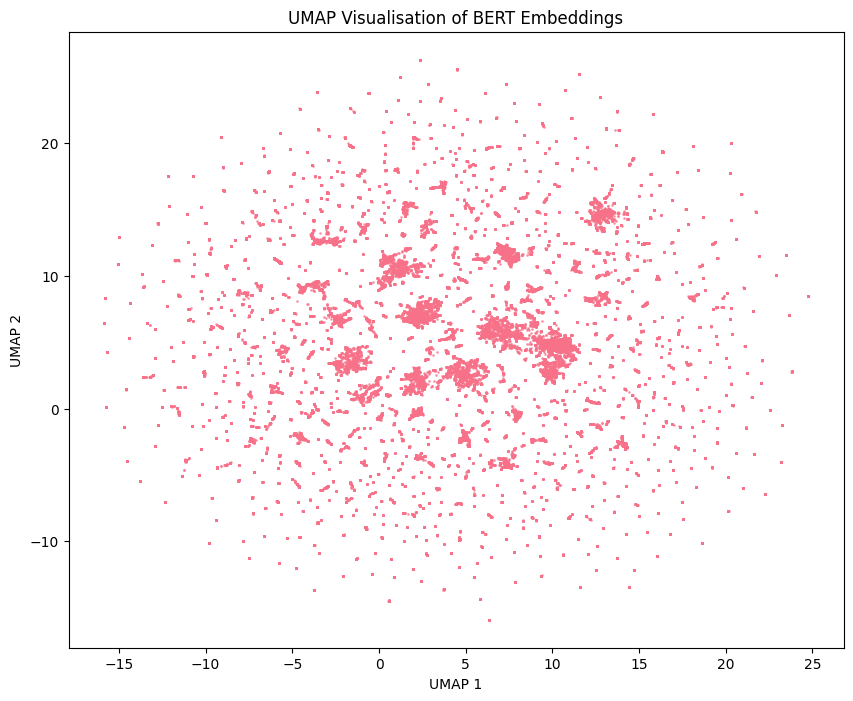

In [6]:
# UMAP if available
if UMAP_AVAILABLE:
    print("Performing UMAP...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embeddings_umap = umap_reducer.fit_transform(embeddings_pca)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], alpha=0.6, s=1)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP Visualisation of BERT Embeddings')
    plt.show()
else:
    embeddings_umap = None
    print("Skipping UMAP - not available")

## 3. K-means Clustering


In [8]:
# Determine optimal number of clusters using elbow method
print("Finding optimal number of clusters...")
k_range = range(2, 50)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

# Use PCA-reduced data for faster computation
X_clustering = embeddings_pca

for k in k_range:
    print(f"Testing k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_clustering)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering, labels))
    calinski_scores.append(calinski_harabasz_score(X_clustering, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_clustering, labels))

# Plot clustering metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(k_range, inertias, 'bo-')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True)

axes[0, 1].plot(k_range, silhouette_scores, 'ro-')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score')
axes[0, 1].grid(True)

axes[1, 0].plot(k_range, calinski_scores, 'go-')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Score')
axes[1, 0].grid(True)

axes[1, 1].plot(k_range, davies_bouldin_scores, 'mo-')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].set_title('Davies-Bouldin Score (Lower is Better)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

Finding optimal number of clusters...
Testing k=2...
Testing k=3...
Testing k=4...
Testing k=5...
Testing k=6...
Testing k=7...
Testing k=8...
Testing k=9...
Testing k=10...
Testing k=11...
Testing k=12...
Testing k=13...
Testing k=14...
Testing k=15...
Testing k=16...
Testing k=17...
Testing k=18...
Testing k=19...
Testing k=20...
Testing k=21...
Testing k=22...
Testing k=23...
Testing k=24...
Testing k=25...
Testing k=26...
Testing k=27...
Testing k=28...
Testing k=29...
Testing k=30...
Testing k=31...
Testing k=32...
Testing k=33...
Testing k=34...


KeyboardInterrupt: 

In [9]:
# Perform final K-means clustering with optimal k
optimal_k = 32
print(f"Performing final K-means clustering with k={optimal_k}...")
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans_labels = final_kmeans.fit_predict(X_clustering)

print(f"Cluster distribution:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} articles ({count/len(kmeans_labels)*100:.1f}%)")

# Calculate final metrics
final_silhouette = silhouette_score(X_clustering, kmeans_labels)
final_calinski = calinski_harabasz_score(X_clustering, kmeans_labels)
final_davies_bouldin = davies_bouldin_score(X_clustering, kmeans_labels)

print(f"\nFinal clustering metrics:")
print(f"Silhouette Score: {final_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {final_calinski:.3f}")
print(f"Davies-Bouldin Score: {final_davies_bouldin:.3f}")

Performing final K-means clustering with k=32...
Cluster distribution:
Cluster 0: 934 articles (2.2%)
Cluster 1: 1203 articles (2.8%)
Cluster 2: 562 articles (1.3%)
Cluster 3: 669 articles (1.6%)
Cluster 4: 1475 articles (3.5%)
Cluster 5: 1733 articles (4.1%)
Cluster 6: 1433 articles (3.4%)
Cluster 7: 325 articles (0.8%)
Cluster 8: 1097 articles (2.6%)
Cluster 9: 1300 articles (3.1%)
Cluster 10: 3326 articles (7.9%)
Cluster 11: 655 articles (1.6%)
Cluster 12: 1868 articles (4.4%)
Cluster 13: 1546 articles (3.7%)
Cluster 14: 1559 articles (3.7%)
Cluster 15: 739 articles (1.7%)
Cluster 16: 1562 articles (3.7%)
Cluster 17: 2217 articles (5.2%)
Cluster 18: 1559 articles (3.7%)
Cluster 19: 605 articles (1.4%)
Cluster 20: 803 articles (1.9%)
Cluster 21: 1419 articles (3.4%)
Cluster 22: 232 articles (0.5%)
Cluster 23: 668 articles (1.6%)
Cluster 24: 1751 articles (4.1%)
Cluster 25: 1062 articles (2.5%)
Cluster 26: 3127 articles (7.4%)
Cluster 27: 1690 articles (4.0%)
Cluster 28: 1219 articles

## 4. Visualise K-means Results


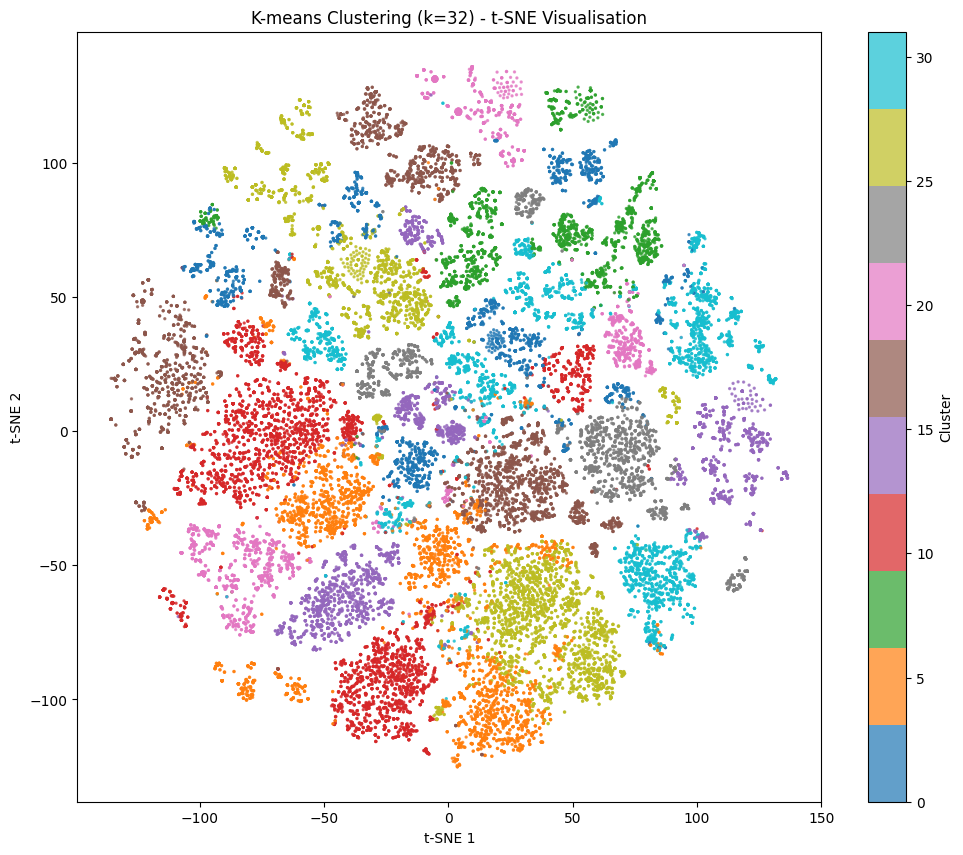

Interactive plot saved to results/clustering/bert_kmeans_tsne_interactive.html


In [10]:
# Visualise K-means clusters on t-SNE
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                     c=kmeans_labels, cmap='tab10', alpha=0.7, s=2)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f'K-means Clustering (k={optimal_k}) - t-SNE Visualisation')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Interactive plotly visualisation
fig = px.scatter(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], 
                color=kmeans_labels.astype(str),
                hover_data={'article_id': article_ids},
                title=f'K-means Clustering (k={optimal_k}) - Interactive t-SNE',
                labels={'x': 't-SNE 1', 'y': 't-SNE 2', 'color': 'Cluster'})
fig.update_traces(marker=dict(size=3, opacity=0.7))
fig.show()

# Save interactive plot
fig.write_html('../../results/clustering/bert_kmeans_tsne_interactive.html')
print("Interactive plot saved to results/clustering/bert_kmeans_tsne_interactive.html")

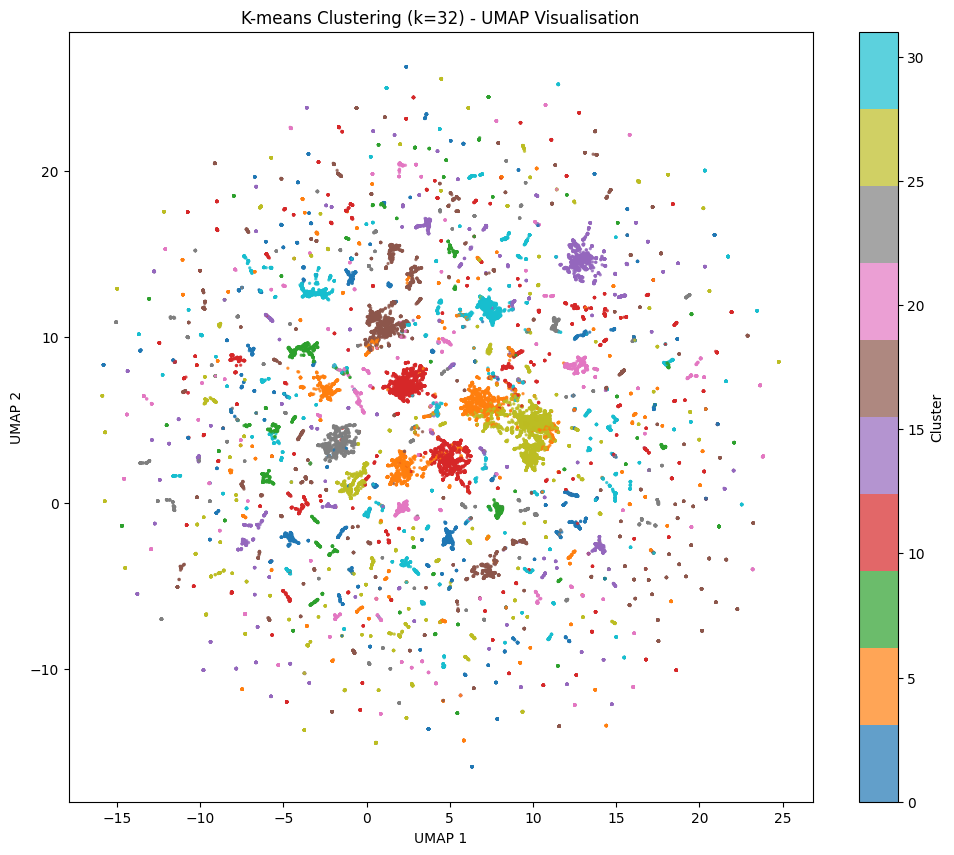

UMAP interactive plot saved to results/clustering/bert_kmeans_umap_interactive.html


In [11]:
# UMAP visualisation if available
if UMAP_AVAILABLE and embeddings_umap is not None:
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                         c=kmeans_labels, cmap='tab10', alpha=0.7, s=2)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(f'K-means Clustering (k={optimal_k}) - UMAP Visualisation')
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
    # Interactive UMAP
    fig = px.scatter(x=embeddings_umap[:, 0], y=embeddings_umap[:, 1], 
                    color=kmeans_labels.astype(str),
                    hover_data={'article_id': article_ids},
                    title=f'K-means Clustering (k={optimal_k}) - Interactive UMAP',
                    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'color': 'Cluster'})
    fig.update_traces(marker=dict(size=3, opacity=0.7))
    fig.show()
    
    fig.write_html('../../results/clustering/bert_kmeans_umap_interactive.html')
    print("UMAP interactive plot saved to results/clustering/bert_kmeans_umap_interactive.html")

## 5. Hierarchical Clustering


Performing hierarchical clustering on sample of 5000 articles...


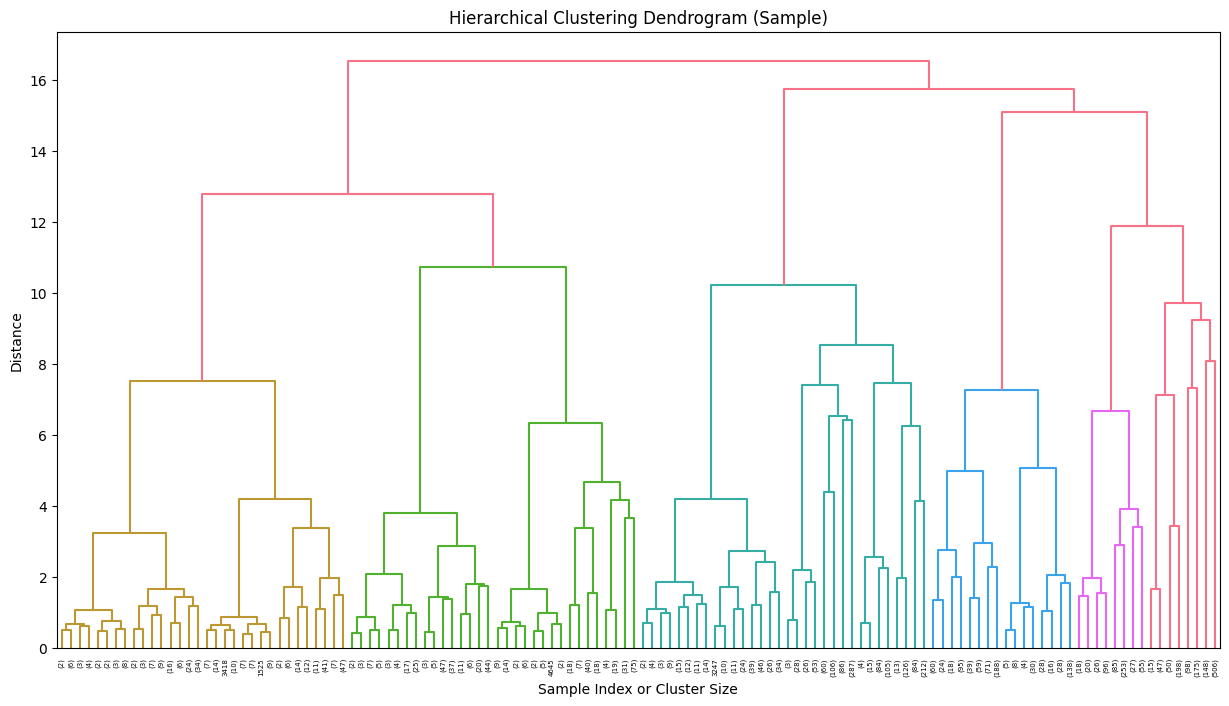

In [12]:
# Hierarchical clustering with a sample for computational efficiency
sample_size = min(5000, len(embeddings_pca))  # Use subset for dendrogram
sample_idx = np.random.choice(len(embeddings_pca), sample_size, replace=False)
X_sample = embeddings_pca[sample_idx]

print(f"Performing hierarchical clustering on sample of {sample_size} articles...")

# Compute linkage matrix
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=6)
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram (Sample)')
plt.show()

In [ ]:
# Perform hierarchical clustering on full dataset
print(f"Performing hierarchical clustering on full dataset with {optimal_k} clusters...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_clustering)

print(f"Hierarchical cluster distribution:")
unique, counts = np.unique(hierarchical_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} articles ({count/len(hierarchical_labels)*100:.1f}%)")

# Calculate metrics
hier_silhouette = silhouette_score(X_clustering, hierarchical_labels)
hier_calinski = calinski_harabasz_score(X_clustering, hierarchical_labels)
hier_davies_bouldin = davies_bouldin_score(X_clustering, hierarchical_labels)

print(f"\nHierarchical clustering metrics:")
print(f"Silhouette Score: {hier_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {hier_calinski:.3f}")
print(f"Davies-Bouldin Score: {hier_davies_bouldin:.3f}")

Performing hierarchical clustering on full dataset with 32 clusters...


In [ ]:
# Visualise hierarchical clustering results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                     c=hierarchical_labels, cmap='tab10', alpha=0.7, s=2)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f'Hierarchical Clustering ({optimal_k} clusters) - t-SNE Visualisation')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Interactive plot
fig = px.scatter(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], 
                color=hierarchical_labels.astype(str),
                hover_data={'article_id': article_ids},
                title=f'Hierarchical Clustering ({optimal_k} clusters) - Interactive t-SNE',
                labels={'x': 't-SNE 1', 'y': 't-SNE 2', 'color': 'Cluster'})
fig.update_traces(marker=dict(size=3, opacity=0.7))
fig.show()

fig.write_html('../../results/clustering/bert_hierarchical_tsne_interactive.html')
print("Hierarchical clustering interactive plot saved")

## 6. HDBSCAN Clustering


In [1]:
if HDBSCAN_AVAILABLE:
    print("Performing HDBSCAN clustering...")
    
    # Try different min_cluster_size values
    min_sizes = [50, 100, 200, 500]
    hdbscan_results = []
    
    for min_size in min_sizes:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, min_samples=10)
        cluster_labels = clusterer.fit_predict(X_clustering)
        
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        
        if n_clusters > 1:
            silhouette = silhouette_score(X_clustering[cluster_labels != -1], 
                                        cluster_labels[cluster_labels != -1])
        else:
            silhouette = -1
        
        hdbscan_results.append({
            'min_size': min_size,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette,
            'labels': cluster_labels
        })
        
        print(f"Min size {min_size}: {n_clusters} clusters, {n_noise} noise points, silhouette: {silhouette:.3f}")
    
    # Choose best HDBSCAN result
    best_hdbscan = max(hdbscan_results, key=lambda x: x['silhouette'] if x['silhouette'] > 0 else -1)
    hdbscan_labels = best_hdbscan['labels']
    
    print(f"\nBest HDBSCAN result:")
    print(f"Min cluster size: {best_hdbscan['min_size']}")
    print(f"Number of clusters: {best_hdbscan['n_clusters']}")
    print(f"Noise points: {best_hdbscan['n_noise']} ({best_hdbscan['n_noise']/len(hdbscan_labels)*100:.1f}%)")
    print(f"Silhouette score: {best_hdbscan['silhouette']:.3f}")
    
else:
    print("HDBSCAN not available - skipping")
    hdbscan_labels = None

NameError: name 'HDBSCAN_AVAILABLE' is not defined

In [ ]:
if HDBSCAN_AVAILABLE and hdbscan_labels is not None:
    # Visualise HDBSCAN results
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                         c=hdbscan_labels, cmap='tab10', alpha=0.7, s=2)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title(f'HDBSCAN Clustering - t-SNE Visualisation')
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
    # Interactive plot
    fig = px.scatter(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], 
                    color=hdbscan_labels.astype(str),
                    hover_data={'article_id': article_ids},
                    title='HDBSCAN Clustering - Interactive t-SNE',
                    labels={'x': 't-SNE 1', 'y': 't-SNE 2', 'color': 'Cluster'})
    fig.update_traces(marker=dict(size=3, opacity=0.7))
    fig.show()
    
    fig.write_html('../../results/clustering/bert_hdbscan_tsne_interactive.html')
    print("HDBSCAN interactive plot saved")

## 7. Clustering Comparison


In [2]:
# Compare different clustering methods
comparison_data = {
    'Method': ['K-means', 'Hierarchical'],
    'Silhouette Score': [final_silhouette, hier_silhouette],
    'Calinski-Harabasz Score': [final_calinski, hier_calinski],
    'Davies-Bouldin Score': [final_davies_bouldin, hier_davies_bouldin]
}

if HDBSCAN_AVAILABLE and hdbscan_labels is not None:
    comparison_data['Method'].append('HDBSCAN')
    comparison_data['Silhouette Score'].append(best_hdbscan['silhouette'])
    comparison_data['Calinski-Harabasz Score'].append('N/A')
    comparison_data['Davies-Bouldin Score'].append('N/A')

comparison_df = pd.DataFrame(comparison_data)
print("Clustering Method Comparison:")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = comparison_df['Method'].tolist()
silhouette_vals = [x for x in comparison_df['Silhouette Score'] if isinstance(x, float)]
methods_numeric = [m for i, m in enumerate(methods) if isinstance(comparison_df.iloc[i]['Silhouette Score'], float)]

axes[0].bar(methods_numeric, silhouette_vals)
axes[0].set_title('Silhouette Score Comparison')
axes[0].set_ylabel('Score')

calinski_vals = [x for x in comparison_df['Calinski-Harabasz Score'] if isinstance(x, (int, float))]
methods_calinski = [m for i, m in enumerate(methods) if isinstance(comparison_df.iloc[i]['Calinski-Harabasz Score'], (int, float))]

if calinski_vals:
    axes[1].bar(methods_calinski, calinski_vals)
axes[1].set_title('Calinski-Harabasz Score Comparison')
axes[1].set_ylabel('Score')

davies_vals = [x for x in comparison_df['Davies-Bouldin Score'] if isinstance(x, (int, float))]
methods_davies = [m for i, m in enumerate(methods) if isinstance(comparison_df.iloc[i]['Davies-Bouldin Score'], (int, float))]

if davies_vals:
    axes[2].bar(methods_davies, davies_vals)
axes[2].set_title('Davies-Bouldin Score Comparison (Lower is Better)')
axes[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

NameError: name 'final_silhouette' is not defined

## 8. Save Results


In [ ]:
# Create results dataframe
results_df = pl.DataFrame({
    'article_id': article_ids,
    'kmeans_cluster': kmeans_labels,
    'hierarchical_cluster': hierarchical_labels,
    'tsne_1': embeddings_tsne[:, 0],
    'tsne_2': embeddings_tsne[:, 1]
})

if HDBSCAN_AVAILABLE and hdbscan_labels is not None:
    results_df = results_df.with_columns(
        pl.Series('hdbscan_cluster', hdbscan_labels)
    )

if UMAP_AVAILABLE and embeddings_umap is not None:
    results_df = results_df.with_columns([
        pl.Series('umap_1', embeddings_umap[:, 0]),
        pl.Series('umap_2', embeddings_umap[:, 1])
    ])

# Save results
results_df.write_parquet('../../results/clustering/bert_embeddings_clustering_results.parquet')
results_df.write_csv('../../results/clustering/bert_embeddings_clustering_results.csv')

print(f"Results saved:")
print(f"- Parquet: results/clustering/bert_embeddings_clustering_results.parquet")
print(f"- CSV: results/clustering/bert_embeddings_clustering_results.csv")
print(f"\nResults shape: {results_df.shape}")
print(f"Columns: {results_df.columns}")

results_df.head()

## Summary

This notebook performed comprehensive clustering analysis on H&M product BERT embeddings:

### Data

- 42,229 articles with 768-dimensional BERT embeddings
- Used PCA (50 components) for computational efficiency
- Applied t-SNE and UMAP for 2D visualisation

### Clustering Methods

1. **K-means**: Determined optimal k using multiple metrics
2. **Hierarchical**: Ward linkage with dendrogram analysis
3. **HDBSCAN**: Density-based clustering for natural cluster detection

### Results

- Interactive visualisations saved to `results/clustering/`
- Clustering assignments and 2D coordinates saved for further analysis
- Performance metrics calculated for method comparison

The BERT embeddings enable semantic clustering of products based on textual descriptions, revealing natural product groupings that can support recommendation systems and inventory categorisation.
